In [1]:
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas

/Users/chulahlou/.conda/envs/forcasting/lib/python3.7/site-packages/gluonts/json.py:46: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  "Using `json`-module for json-handling. "


In [2]:
import warnings
warnings.filterwarnings("ignore")

from typing import List, Optional, Callable, Iterable
from itertools import islice

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

In [3]:
print(f"Available datasets:  \n" + "\n".join(dataset_recipes.keys()))

Available datasets:  
constant
exchange_rate
solar-energy
electricity
traffic
exchange_rate_nips
electricity_nips
traffic_nips
solar_nips
wiki-rolling_nips
taxi_30min
kaggle_web_traffic_with_missing
kaggle_web_traffic_without_missing
kaggle_web_traffic_weekly
m1_yearly
m1_quarterly
m1_monthly
nn5_daily_with_missing
nn5_daily_without_missing
nn5_weekly
tourism_monthly
tourism_quarterly
tourism_yearly
m3_monthly
m3_quarterly
m3_yearly
m3_other
m4_hourly
m4_daily
m4_weekly
m4_monthly
m4_quarterly
m4_yearly
m5


In [4]:
dataset = get_dataset("electricity", regenerate=False)

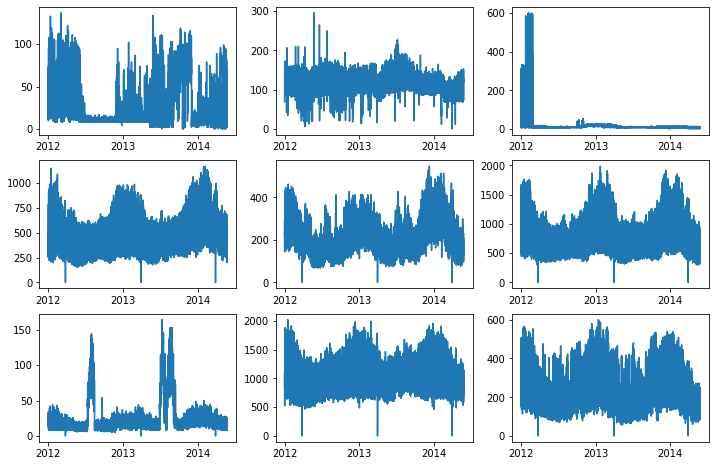

In [5]:
date_formater = mdates.DateFormatter('%Y')

fig = plt.figure(figsize=(12,8))
for idx, entry in enumerate(islice(dataset.train, 9)):
    ax = plt.subplot(3, 3, idx+1)
    t = pd.date_range(start=entry["start"], periods=len(entry["target"]), freq=entry["start"].freq)
    plt.plot(t, entry["target"])
    plt.xticks(pd.date_range(start=pd.to_datetime("2011-12-31"), periods=3, freq="AS"))
    ax.xaxis.set_major_formatter(date_formater)

In [6]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer

In [7]:
context_length = 2 * 7 * 24

In [15]:
len(x['target'])

21044

In [ ]:
estimator = DeepAREstimator(
    freq=dataset.metadata.freq,
    prediction_length=dataset.metadata.prediction_length,
    context_length=context_length,
    trainer=Trainer(
        ctx="cpu",
        epochs=10,
        learning_rate=1e-3,
        num_batches_per_epoch=100
    )
)

In [ ]:
predictor = estimator.train(dataset.train)

In [ ]:
from gluonts.dataset.field_names import FieldName
from gluonts.transform import AddObservedValuesIndicator, InstanceSplitter, ExpectedNumInstanceSampler, TestSplitSampler
from gluonts.evaluation import make_evaluation_predictions, Evaluator

In [ ]:
mask_unobserved = AddObservedValuesIndicator(
    target_field=FieldName.TARGET,
    output_field=FieldName.OBSERVED_VALUES,
)

In [ ]:
prediction_splitter = InstanceSplitter(
    target_field=FieldName.TARGET,
    is_pad_field=FieldName.IS_PAD,
    start_field=FieldName.START,
    forecast_start_field=FieldName.FORECAST_START,
    instance_sampler=TestSplitSampler(),
    past_length=context_length,
    future_length=dataset.metadata.prediction_length,
    time_series_fields=[FieldName.OBSERVED_VALUES],
)

In [ ]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test, 
    predictor=predictor
)

forecasts_pytorch = [f for f in forecast_it]
tss_pytorch = list(ts_it)

In [ ]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts_pytorch, tss_pytorch)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-5 * dataset.metadata.prediction_length:], label="target")
    forecast.plot()
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [ ]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])

In [ ]:
metrics_pytorch, _ = evaluator(iter(tss_pytorch), iter(forecasts_pytorch), num_series=len(dataset.test))
pd.DataFrame.from_records(metrics_pytorch, index=["DeepAR"]).transpose()